In [ ]:
###############################
## CREATE CLASS: DATA-SET THAT CONTAINS:
##     IMG, IMG_FLATTEN, N_OBJ, N_OBJ_ONEHOT, TOTAL_AREAS,
##########################################################

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from skimage.morphology import convex_hull_image
from skimage import data, img_as_float
from skimage.util import invert
import matplotlib.pyplot as plt


class SquareDataSet():
  
    def __init__(self, img_flatten, n_obj_onehot, total_areas=None):
        self.img_flatten = img_flatten
        self.n_obj_onehot = n_obj_onehot        
        self.img = np.reshape(img_flatten, (-1,img_size,img_size))
        self.n_obj = np.argmax(n_obj_onehot,axis=1)+1        
        self.hull = self.get_convex_hull()
        
        if(total_areas is None):
          self.total_areas = self.get_total_areas()
        else:
          self.total_areas = total_areas
                
    def subset_conditioned(self, area=-1, n_obj=-1, hull=-1):
        
        subset_ = SquareDataSet(self.img_flatten, self.n_obj_onehot,self.total_areas)
        
        if(area>=0):
          area_indices = np.where(subset_.total_areas == area)[0]
          subset_ = subset_.subset(subset_, area_indices)
        
        if(n_obj>=0):
          n_obj_indices = np.where(subset_.n_obj == n_obj)[0]
          subset_ = subset_.subset(subset_, n_obj_indices)
        
        if(hull>=0):
          n_hull_indices = np.where(subset_.hull == hull)[0]
          subset_ = subset_.subset(subset_, n_hull_indices)
        
        return subset_
          
    def subset(self, set_, indices):
        img_flatten = set_.img_flatten[indices]
        n_obj_onehot = set_.n_obj_onehot[indices]
        total_areas = set_.total_areas[indices]
        
        img = set_.img[indices]
        n_obj = set_.n_obj[indices]
        
        return SquareDataSet(img_flatten, n_obj_onehot,total_areas)
      
    def get_convex_hull(self):
            
        image = self.img[0]
        chull = convex_hull_image(image)
        binary_hull = chull.copy().astype(int)
        hull_scalar = np.sum(binary_hull)
        hull = hull_scalar
        
        for i in range(1,self.n_obj.size ):
            
            image = self.img[i]
            chull = convex_hull_image(image)
            binary_hull = chull.copy().astype(int)
            hull_scalar = np.sum(binary_hull)
            
            hull = np.vstack( (hull, hull_scalar) )
            
        return hull
      
    def get_total_areas(self):
       
        total_areas = np.sum(self.img[0]/255)

        for i in range(1,self.n_obj.size ):

            total_area = np.sum(self.img[i]/255)
            total_areas = np.vstack( (total_areas, total_area) )

        return total_areas
      

    def show_images(self,listy, hull=False ):
        #from https://scikit-image.org/docs/dev/auto_examples/edges/plot_convex_hull.html
        
        if(type(listy) == int):
          listy = range(listy)
        
        for i in listy:
                       
            if(hull):
                chull = convex_hull_image(self.img[i])
                chull_diff = img_as_float(chull.copy())
                img = self.img[i]/255
                img = img.astype(bool)
                chull_diff[img.reshape(28,28)] = 2

                fig, ax = plt.subplots()
                ax.imshow(chull_diff, cmap=plt.cm.gray)
                ax.set_title('Image and convex hull')

                plt.tight_layout()
                plt.show()
            else:
                img = self.img[i]/255
                img = img.astype(bool)

                fig, ax = plt.subplots()
                ax.imshow(img, cmap=plt.cm.gray)
                ax.set_title('Image')

                plt.tight_layout()
                plt.show()

In [ ]:
###################################
## CREATE IMAGES WITH RANDOMLY                   NEWWWWWWWW
##  POSITIONED SQUARES WITH VARIED SIZE          NEWWWWWWWW: 1) possible individual areas: 1²,3²,5² --> 1²,2²,3²,4²,5²  2) control for fixed area, fixed individual area, fixed accumulative area, 
#################################
# Good source about pixel manipulation: http://pythoninformer.com/python-libraries/numpy/numpy-and-images/

import numpy as np
import scipy.misc as smp
import random
from PIL import Image
from IPython.display import display
from IPython.display import HTML
style = "<style>svg{width:500% !important;height:500% !important;}</style>"


max_objects_ = 10
img_size = 28

area_chunk = 5

def myround(x, base=5):
    return base * round(x/base)

###################################
## Function that creates N (= argument of the function) Squares
##  randomly positioned with varying size
##  AND corresponding one-hot-encoded number of objects .
########
def Create_N_Sqaures(n_objects, fixed_area=False, area_=1):

    
    min_side_length = 1
    max_side_length = 5
    
    data = np.zeros((img_size, img_size), dtype=np.uint8)                                          
    total_area = 0
    max_objects = max_objects_


    for n in range(n_objects):
      
        new_attempt_all_squares = True
        
        while(new_attempt_all_squares==True):
            breaky = 0
            max_put_try = 4000    #Number of attempts to place square correctly: without overlap, within the borders of the image.
            put_try=0
            
            side_length =  random.randint(min_side_length,max_side_length)
            if(fixed_area):
                side_length = area_
            

            # Now try to put square correctly into image for max_put_try attempts.
            # Strategy: choose random x and y to set left-lowest corner of square and check whethter it intersects with existing squares
            while (breaky == 0):
              
                dist_around_squ = 2
                dist_to_squ = dist_around_squ
                
                rand_pixel_1 = random.randint(dist_around_squ,img_size-side_length-dist_around_squ)
                rand_pixel_2 = random.randint(dist_around_squ, img_size-side_length-dist_around_squ)

                
                # Check if object does not intersect with other
                breaky = 1
                for i in range(-dist_to_squ, side_length + dist_to_squ):
                    for j in range(-dist_to_squ, side_length + dist_to_squ):
                          if(data[rand_pixel_1 + i, rand_pixel_2 + j] == 255):
                              breaky=0

                put_try += 1
                
                # If tried max_put_try/20 time with the current size create new size of square (gets chance to be smaller and fit now)
                if(put_try%(max_put_try/20)==0 ): 
                    side_length =  random.randint(min_side_length,max_side_length)
                    if(fixed_area):
                        side_length = area_
                
                if(put_try >= max_put_try):
                    breaky = 1
                    print("ATTENTION: OBJECTS COULD NOT FIT INTO WINDOW. CHOOSE DIFFERENT SIZE FOR WINDOW OR OBJECTS")
                    #exit()
                    new_attempt_all_squares = True
                else:
                    new_attempt_all_squares = False
                
        data[rand_pixel_1,rand_pixel_2] = 255

        for i in range(side_length):
            for j in range(side_length ):
                data[rand_pixel_1 + i, rand_pixel_2 + j] = 255

        square_area = side_length*side_length
        total_area +=square_area
    

    # Data 2D-image --> 1D-array ( for NN as Input )
    data_flatten = data.flatten()
    # Build one-hot array from number of objects
    n_obj_one_hot = np.zeros(max_objects)
    n_objects_m_1 = n_objects-1
    n_obj_one_hot[n_objects_m_1] = 1
    
    return data_flatten, n_obj_one_hot, total_area




###################################
## Function that creates N images with set of squares
##   AND corresponding one-hot-encoded number of objects.
######
def Create_N_Images(n_images, only_one_number=False, n_squares=5, fixed_area=False, area_=1, max_objects= max_objects_):

    areas = np.zeros((max_objects*25+1, max_objects+1))
    orig_areas = np.zeros((max_objects*25+1, max_objects+1))
  
    n_objects = random.randint(1, max_objects)
        
    if (only_one_number):
        n_objects = n_squares
    
    mult_img, mult_class, mult_total_areas = Create_N_Sqaures(n_objects, fixed_area, area_)
    for i in range(n_images-1):
      
        n_objects = random.randint(1, max_objects)
        if (only_one_number):
            n_objects = n_squares

        data_flatten, n_obj_one_hot, total_area = Create_N_Sqaures(n_objects, fixed_area, area_)
        mult_img = np.vstack([mult_img, data_flatten])
        mult_class = np.vstack((mult_class, n_obj_one_hot))
        mult_total_areas = np.vstack((mult_total_areas, total_area))
        
        areas[total_area][n_objects]+=1
        #orig_areas[orig_area][n_objects]+=1
        
    data_set = SquareDataSet(mult_img, mult_class, mult_total_areas)    
    
    return data_set




####################################
## DEMONSTRATION HOW TO USE DATA SET
####################################


####################
## 1) Create data set 
##################################
# --> will return an instance of the class SquareDataSet()
# 1st argument corresponds to number of pictures/samples
# only_one_number should be set true if you want all the samples to consist only pictures with n_squares squares. Fixed area should be set true if all the pictures have only squares with same side length = area_
data_set = Create_N_Images(300, only_one_number=False, n_squares=5, fixed_area=False, area_=2)   # n_squares will only be considered if only_one_number==True,  area_ only if fixed_area==True

####################
## 2) Extract data from class  
##################################
# choose whatever you need to feed into your NN or use otherwise
# Each of the extracted will be an array of length n_samples
img = data_set.img   
img_flatten = data_set.img_flatten
n_obj = data_set.n_obj
n_obj_onehot = data_set.n_obj_onehot
total_areas = data_set.total_areas
hulls = data_set.hull

####################
## 3) Show images of the dataset  
##################################
# 1st argument: number of pictures that should be shown from the dataset. can also be given as list of indices 
# 2nd argument: if the pictures should be shown with or without the convex hull
data_set.show_images(2, hull=True)
data_set.show_images([3,8], hull=False)

####################
## 4) Get a subset of the data_set with certain constrains  
##################################
subset_1 = data_set.subset_conditioned(area=25)
subset_2 = data_set.subset_conditioned(n_obj=3)
#subset_3 = data_set.subset_conditioned(hull=255)
subset_4 = data_set.subset_conditioned(area=27, n_obj=3)


## Remark
# The data set can be constrained at two points:
# 1. when creating the data set: on constant individual area and on the number of squares
# 2. after the data set has been created, one can take a subset of this: on the total area, on the convex hull and on the number of squares
# The reason the different constraints is that some of the parameters are easier controllable during the creation then afterwards or vice versa (such as the convex hull)
# Also if one wants to have a larger data set with certain constraints, it might be better to put them at creation time already, since the subset of a given data set with certain
# constraint (such as low areas), might be too small to do a proper analysis



  ######################################
## CREATE, SAVE AND LOAD DATA-SET
######################################
#                |  
#                | 
#                | 
#                | 
#                V  ######################################
## CREATE DATA SET
######################################
from sklearn.model_selection import train_test_split

#data_set_train = Create_N_Images(21000, only_one_number=False, n_squares=5, fixed_area=False, area_=2)   
#data_set_test = Create_N_Images(9000, only_one_number=False, n_squares=5, fixed_area=False, area_=2)   

# Extract needed data   
#trX = data_set_train.img_flatten
#trY = data_set_train.n_obj_onehot
#teX = data_set_test.img_flatten
#teY = data_set_test.n_obj_onehot

#trX = data_set.img
#trY = data_set.n_obj

In [ ]:
subset_2 = data_set.subset_conditioned(n_obj=3)
subset_2.show_images(10, hull=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
###########################
## Create equal-size square data-set
####################################

data_folder_path = '/content/drive/MyDrive/Number_Estimation/numerosity-estimation-master-data/data/equal_square_size/'

# create dataset ad dump it in pickle file 
tot_imgs = 60000
data_set_test = Create_N_Images(tot_imgs, only_one_number=False, n_squares=1, fixed_area=True, area_=3)   



# create and save dataframe
y = data_set_test.n_obj
hull = data_set_test.hull.flatten()
area_tot = data_set_test.total_areas.flatten()
imgs = data_set_test.img_flatten
index = range(tot_imgs)
data = {'num':y, 'area': area_tot, 'hull': hull, 'index': index} 
df = pd.DataFrame(data=data)
PATH = data_folder_path + 'data_equal_square_size_60000.csv'
df.to_csv (PATH, index = None, header=True)
# save flattened images
imgs = data_set_test.img_flatten
PATH = data_folder_path + 'data_equal_square_size_60000.npy'
np.save(PATH, imgs) 

NameError: ignored

In [ ]:
import pandas as pd
df = pd.DataFrame(data=data)
PATH = data_folder_path + 'data_equal_square_size_60000.csv'
df.to_csv (PATH, index = None, header=True)
# save flattened images
imgs = data_set_test.img_flatten
PATH = data_folder_path + 'data_equal_square_size_60000.npy'
np.save(PATH, imgs) 

In [ ]:
img = data_set_train.img[0]
img.shape

(28, 28)

In [ ]:
data_set_train.hull.shape

(21000, 1)

### create test dataset and dataframe

In [ ]:
import pandas as pd
import random
import seaborn as sns

- create dataframe

In [ ]:
tot_imgs = 100000
#data_set_train = Create_N_Images(21000, only_one_number=False, n_squares=5, fixed_area=False, area_=2)   
data_set_test = Create_N_Images(tot_imgs, only_one_number=False, n_squares=1, fixed_area=False, area_=2)   
# Extract needed data   
#trX = data_set_train.img_flatten
#trY = data_set_train.n_obj_onehot
teX = data_set_test.img_flatten
teY = data_set_test.n_obj_onehot

In [ ]:
type(teX)

numpy.ndarray

In [ ]:
np.save('/home/cele/datas/teX.npy', teX)
np.save('/home/cele/datas/teY.npy', teY)

In [ ]:
y = data_set_test.n_obj
hull = data_set_test.hull.flatten()
area_tot = data_set_test.total_areas.flatten()
imgs = data_set_test.img_flatten
index = range(tot_imgs)

In [ ]:
data = {'num':y, 'area': area_tot, 'hull': hull, 'index': index} 
df = pd.DataFrame(data=data)
df.head(10)

,num,area,hull,index
0,5,19,257,0
1,5,62,287,1
2,5,35,163,2
3,5,34,178,3
4,5,13,171,4
5,5,60,283,5
6,5,29,300,6
7,5,75,218,7
8,5,72,316,8
9,5,32,268,9


In [ ]:
df.sort_values('area').head()

,num,area,hull,index
167,5,5,271,167
934,5,11,146,934
637,5,11,176,637
156,5,11,203,156
36,5,13,190,36


In [ ]:
data = {'num':y, 'area': area_tot, 'hull': hull, 'index': index} 
df = pd.DataFrame(data=data)
num = 7
df = df[df.num == num]
df.shape

(0, 4)

In [ ]:
sel_hull = []
for k in df.hull.unique():
    if len(df[df.hull==k].area.values)>10:
        sel_hull.append(k)
len(sel_hull)

0

In [ ]:
sel_areas = []
for k in df.area.unique():
    if len(df[df.area==k].hull.values)>10:
        sel_areas.append(k)
len(sel_areas)

0

In [ ]:
df50.sort_values('hull').index.values

array([355, 270, 192, 141, 276, 241, 488, 289, 409, 773, 856, 529, 564,
       634, 275, 953, 774, 949, 657, 648, 710, 592, 978, 818, 935])

131


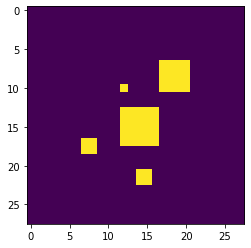

163


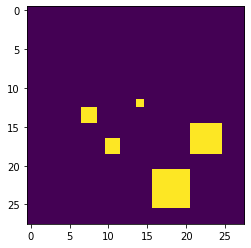

165


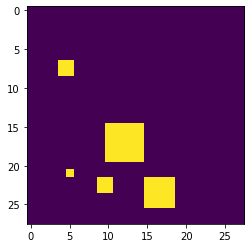

175


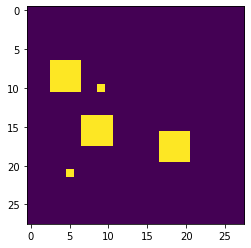

190


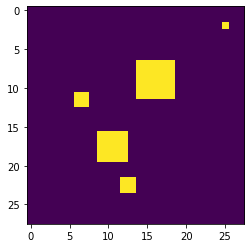

193


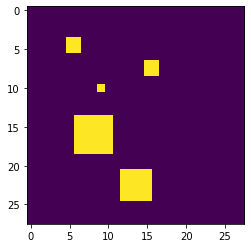

221


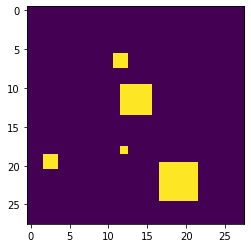

223


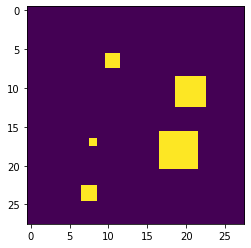

225


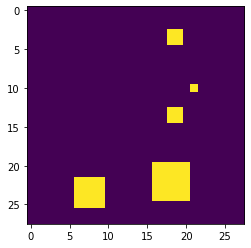

226


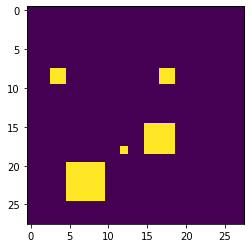

233


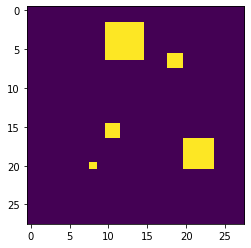

238


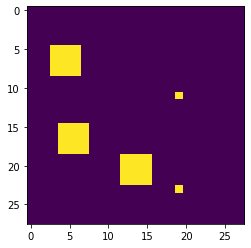

242


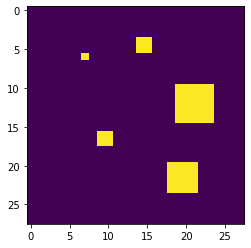

245


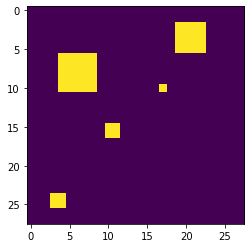

246


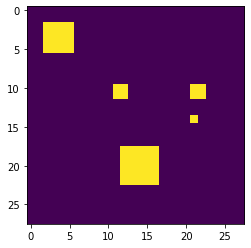

256


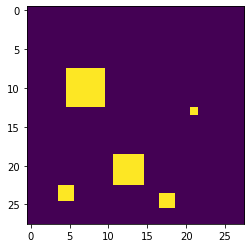

256


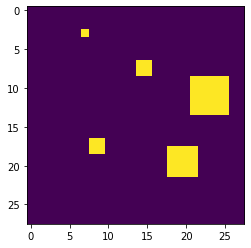

262


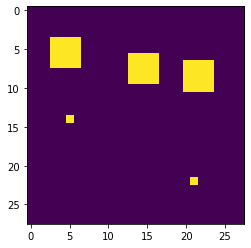

296


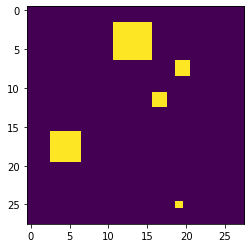

300


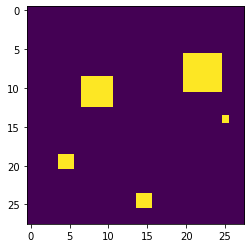

306


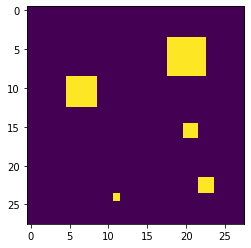

316


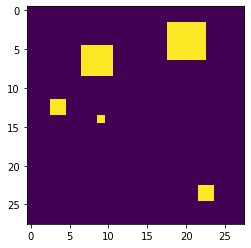

325


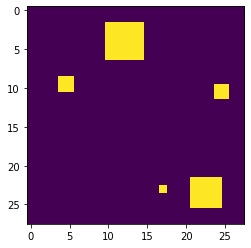

327


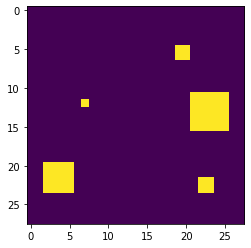

351


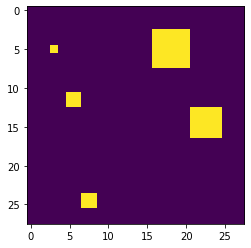

In [ ]:
for k in df50.sort_values('hull').index.values:
    print (df50.sort_values('hull').hull[k])
    plt.imshow(imgs[k].reshape(28,28))
    plt.show()
    

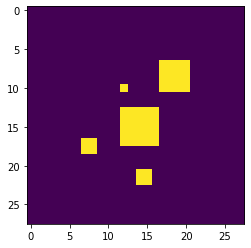

In [ ]:
plt.imshow(imgs[355].reshape(28,28))

### Pairwise relationships among numerosity, total_area and convex_hull

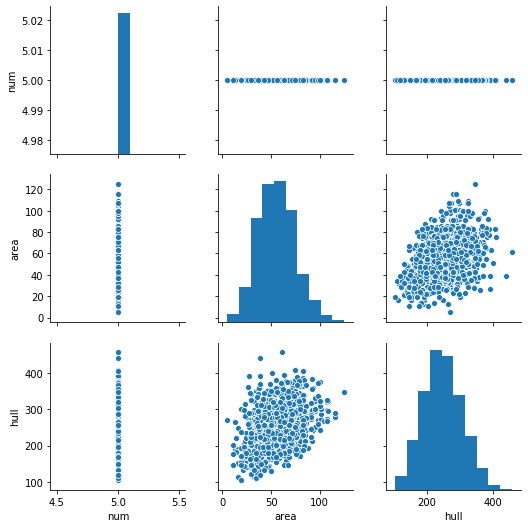

In [ ]:
sns.pairplot(df[['num','area','hull']]);

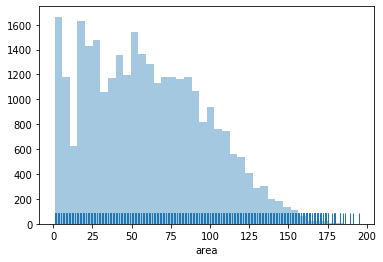

In [ ]:
sns.distplot(df['area'], bins=40, kde=False, rug=True)

### total_area per numerosity

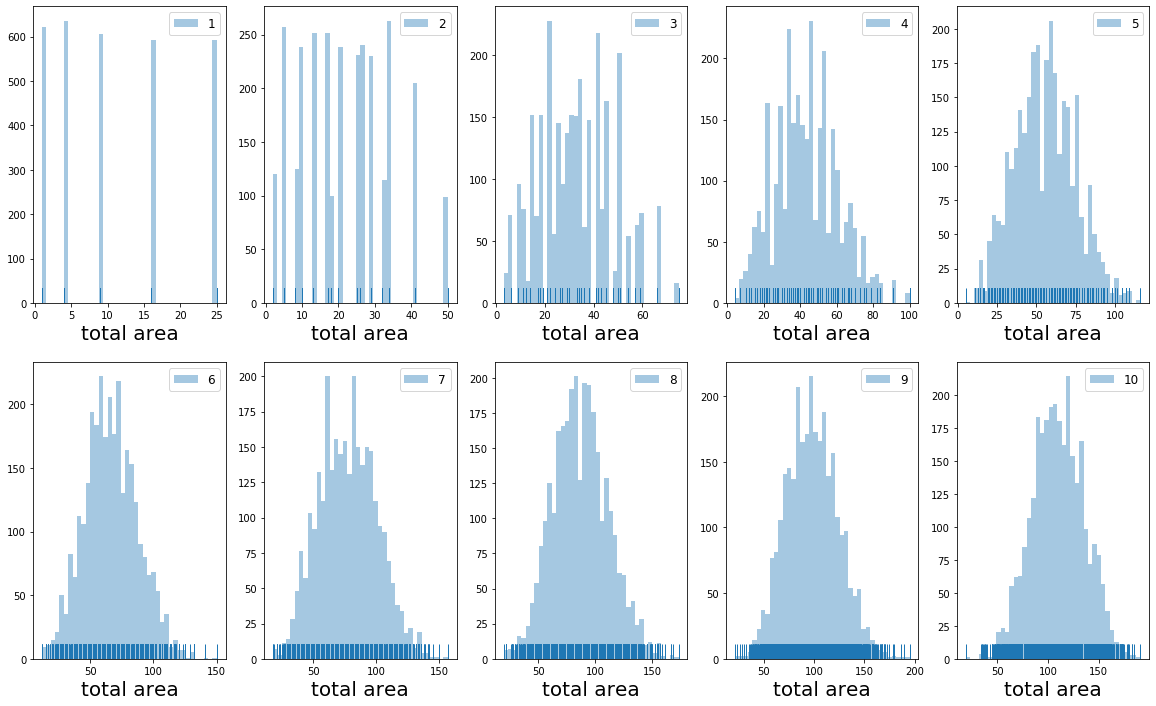

In [ ]:
fig = plt.figure(figsize=(20, 12))
for i in range(1,11,1):
    plt.subplot(2, 5, i)
    b = sns.distplot(df[df.num==i].area, kde=False, bins=40, label=str(i), rug=True)
    plt.legend(prop={'size': 12})
    b.set_xlabel("total area",fontsize=20)
    #df[df.label==i].area.hist()
plt.show()

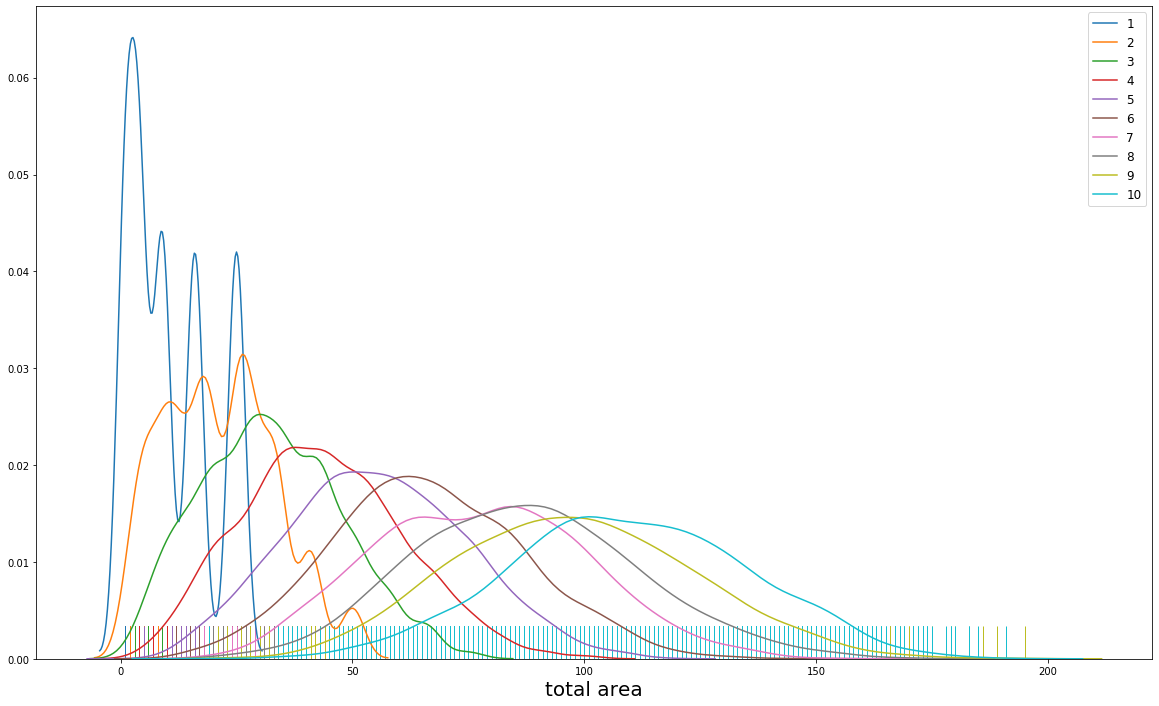

In [ ]:
fig = plt.figure(figsize=(20, 12))
for k in range(1,11,1):
    b = sns.distplot(df[df.num==k]['area'], label=str(k), hist = False, kde = True, rug=True)  
    plt.legend(prop={'size': 12})
    b.set_xlabel("total area",fontsize=20)

### convex hull per numerosity

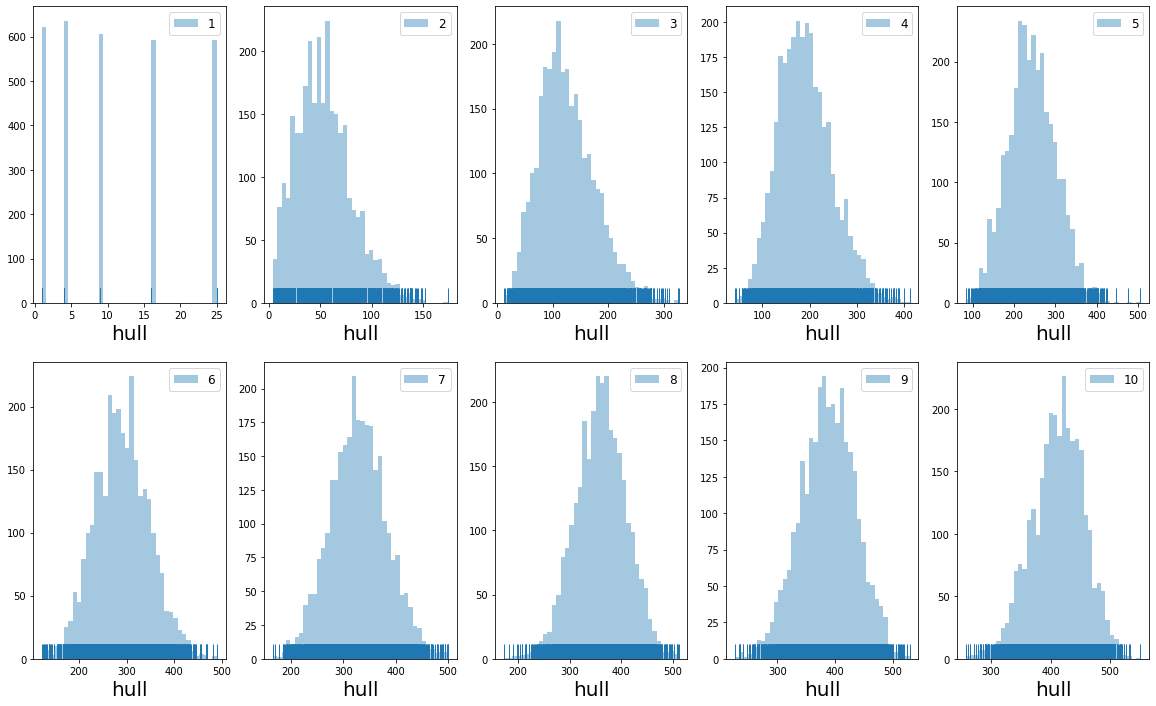

In [ ]:
fig = plt.figure(figsize=(20, 12))
for i in range(1,11,1):
    plt.subplot(2, 5, i)
    b = sns.distplot(df[df.num==i].hull, kde=False, bins=40, label=str(i), rug=True)
    plt.legend(prop={'size': 12})
    b.set_xlabel("hull",fontsize=20)
    #df[df.label==i].area.hist()
plt.show()

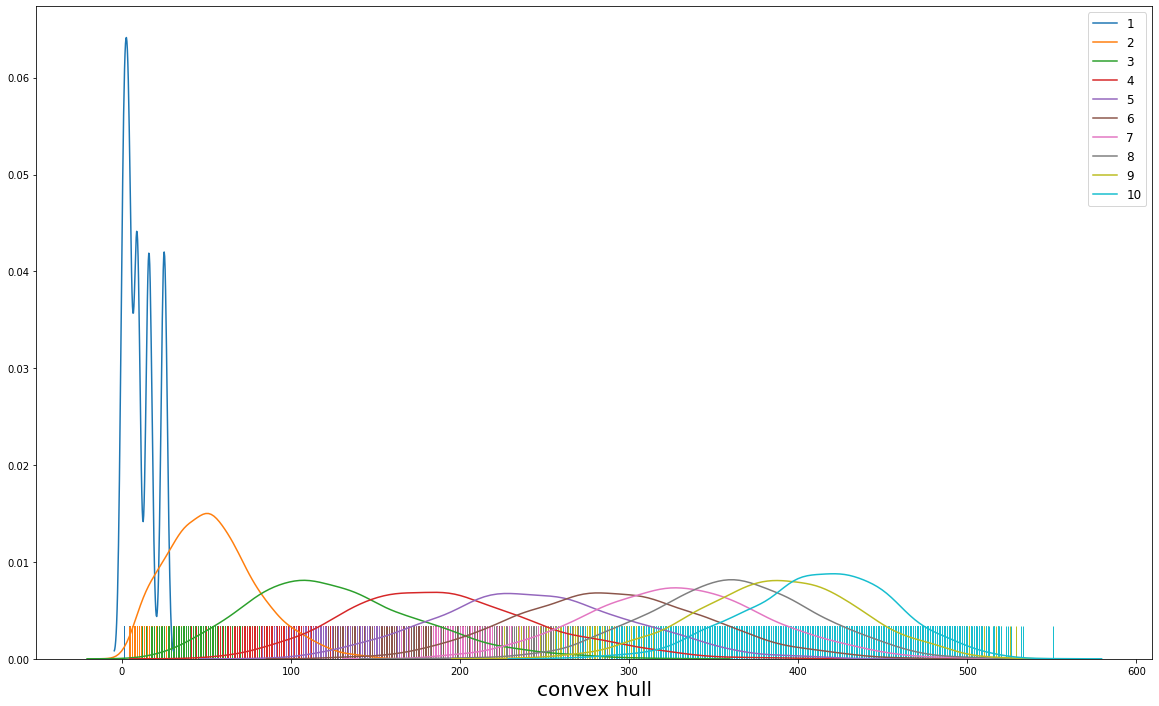

In [ ]:
fig = plt.figure(figsize=(20, 12))
for k in range(1,11,1):
    b = sns.distplot(df[df.num==k]['hull'], label=str(k), hist = False, kde = True, rug=True)  
    plt.legend(prop={'size': 12})
    b.set_xlabel("convex hull",fontsize=20)

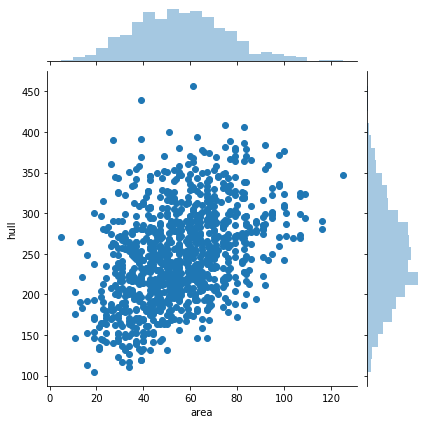

In [ ]:
sns.jointplot(x="area", y="hull", data=df[df.num==5]);